## learning-AI : deep learning application (61357002)
### assignment : diabetes regression (DL)

**당뇨 데이터를 1D-CNN 하여 regression (split_sequence 사용)**

<br>

- **임규연 (lky473736)**
- 2024.09.18.에 문서 작성
- **dataset** : https://github.com/plotly/datasets/blob/master/diabetes.csv
- **kaggle** : https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data
- **data abstract** : This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

------

## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 diabetes를 regression한다. **1D-CNN을 통하여 regression한다.** split_sequence()를 하여 CNN을 진행할 때 주의할 점은 아래와 같다.

- `(주의할 점 1) 적절한 timestep`
    - **앞으로는 EDA를 하기 전, uci dataset에 대한 설명을 먼저 정독한 후에 진행하자.**
    - 만약 특정 시계열 데이터셋이 있다고 가정할 때, 그에 대한 샘플링 속도는 50Hz라고 한다면, 이는 1초 동안 50개의 데이터를 수집했다는 의미이다. -> **따라서 1초 간의 활동을 포착하려고 할 때 타임스텝은 50으로 설정해야 하는 것이 일반적이다.**
    
- `(주의할 점 2) label counting의 불균형을 확인할 것 (classification일 때)`
    - **부족한 label에 해당되는 records의 수를 늘린다. (oversampling)**
    - 반대로, 너무 많은 label에 해당되는 records의 수는 감소한다. (undersampling)
    
- `(주의할 점 3) 많은 양의 records (classification일 때)`
    - 파일에 들어있는 records 수가 많으면 시간 측면에서도 오래 걸리며, 원할한 학습이 이루어지지 않을 수 있다.
    - 따라서 데이터셋 중에서도, label이 고르고 각 feature가 정규분포 모양을 잘 따르고 있는 데이터셋을 선정하여 학습하는 것이 중요하다.



------


In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [194]:
df = pd.read_csv('../../data/diabetes.csv')

df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [195]:
# 결측치 확인 및 결측치를 각 열의 평균값으로 대체

for feature in df.columns :
    print (f'{feature}열의 결측치 존재 여부 : ', df[feature].isnull())
    print ('\n--------------\n')

print ("데이터의 총 결측치 수 : ", df.isnull().sum())

Pregnancies열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: Pregnancies, Length: 768, dtype: bool

--------------

Glucose열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: Glucose, Length: 768, dtype: bool

--------------

BloodPressure열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: BloodPressure, Length: 768, dtype: bool

--------------

SkinThickness열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
763    False
764    False
765    False
766    False
767    False
Name: SkinThickness, Length: 768, dtype: bool

--------------

Insulin열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4

In [196]:
# df의 기본적인 통계량 수치 파악, 각 열마다의 데이터 타입 

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Pregnancies의 데이터 타입 :  int64
Glucose의 데이터 타입 :  int64
BloodPressure의 데이터 타입 :  int64
SkinThickness의 데이터 타입 :  int64
Insulin의 데이터 타입 :  int64
BMI의 데이터 타입 :  float64
DiabetesPedigreeFunction의 데이터 타입 :  float64
Age의 데이터 타입 :  int64
Outcome의 데이터 타입 :  int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


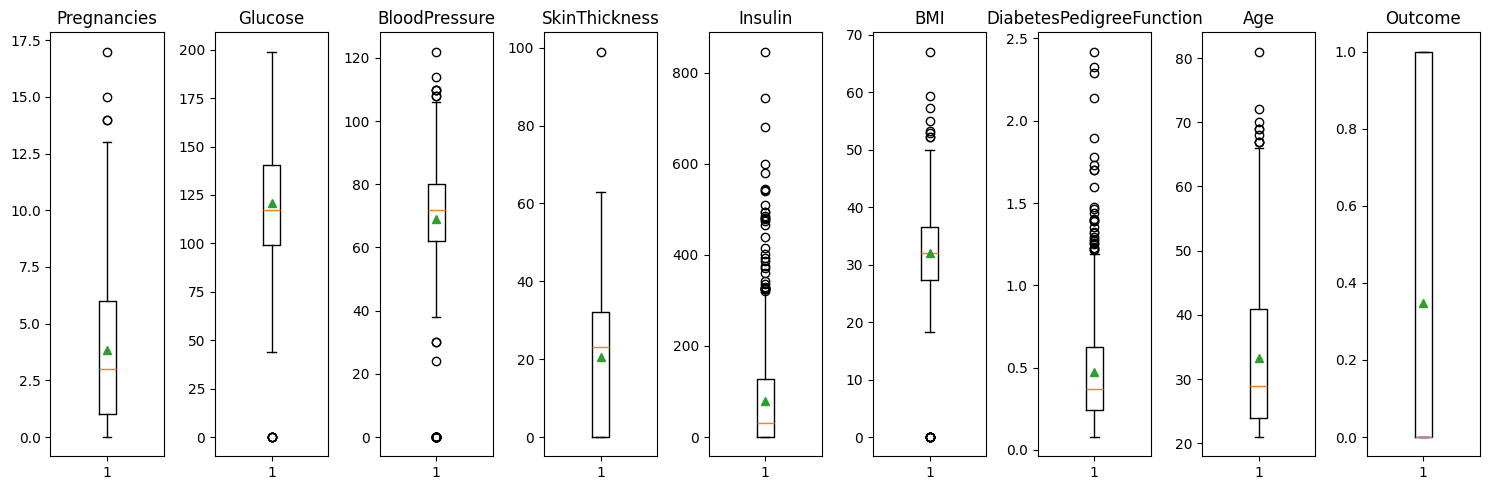

In [197]:
# box plot 그려 데이터 분포 확인

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

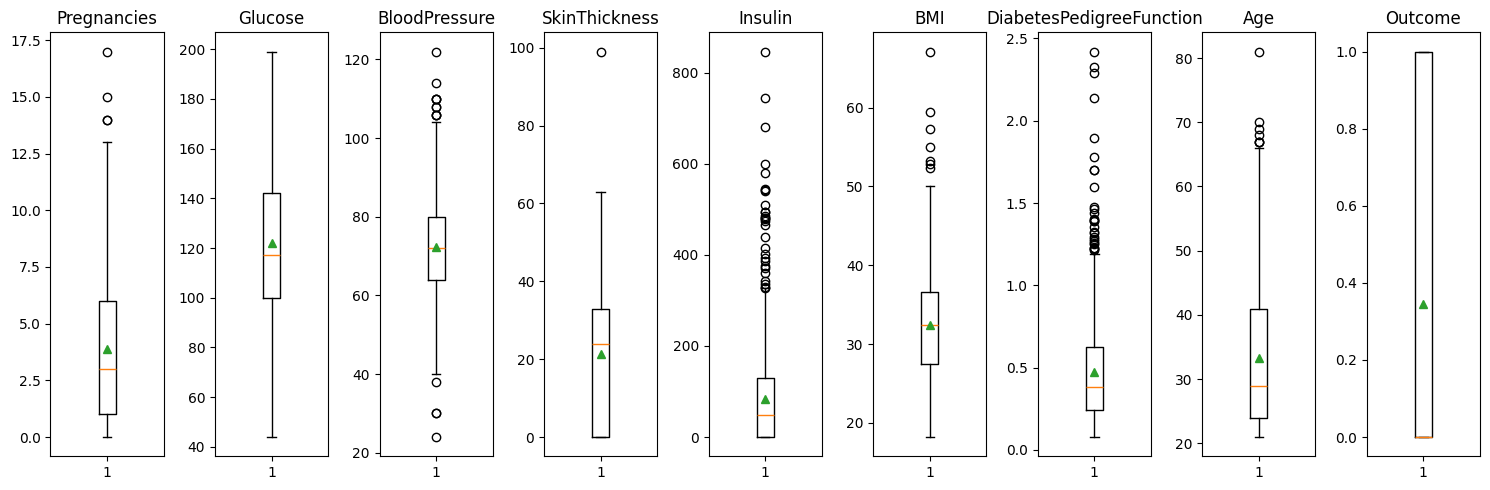

In [198]:
# outlier 제거 및 다시 boxplot 시각화

df = df[(df['BMI'] != 0) & (df['Glucose'] != 0) & (df['BloodPressure'] != 0)]

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5))

for i, var in enumerate(df.columns) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

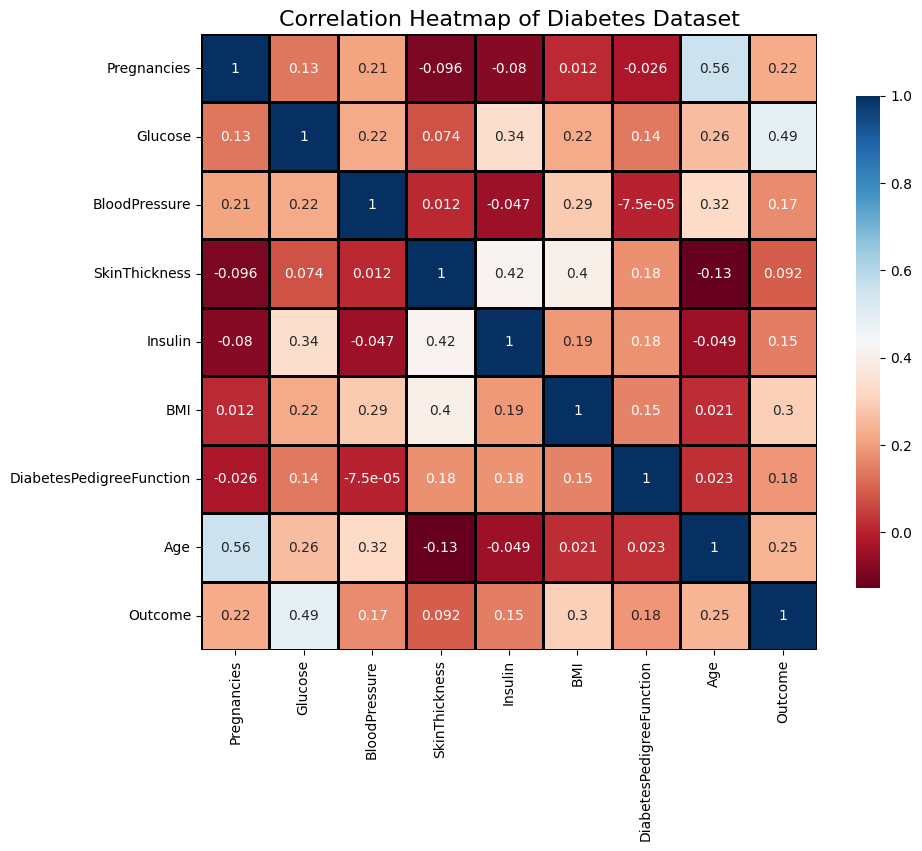

In [199]:
# heatmap

correlation_matrix = df[df.columns].corr() 
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Diabetes Dataset', fontsize=16)
plt.show()

본 데이터프레임에서의 각 attribute는 다음과 같은 내용을 의미한다.

- **임신 횟수 (Pregnancies)** : 임신한 횟수
- **포도당 (Glucose)** : 경구 포도당 내성 검사에서 2시간 후의 혈장 포도당 농도
- **혈압 (BloodPressure)** : 이완기 혈압 (mm Hg)
- **피부 두께 (SkinThickness)** : 삼두근 피부 두께 (mm)
- **인슐린 (Insulin)** : 2시간 후의 혈청 인슐린 (mu U/ml)
- **체질량 지수 (BMI)** : 체질량 지수 (몸무게(kg) / (키(m))^2)
- **당뇨병 혈통 함수 (DiabetesPedigreeFunction)** : 당뇨병 혈통 함수
- **나이 (Age)** : 나이 (년)
- **결과 (Outcome)** : 클래스 변수 (0 또는 1)

**regression의 target은 'BMI'가 될 것이다.** 따라서 추후에 feature dataset을 구성할 때 Outcome에 해당되는 열을 제거한다.

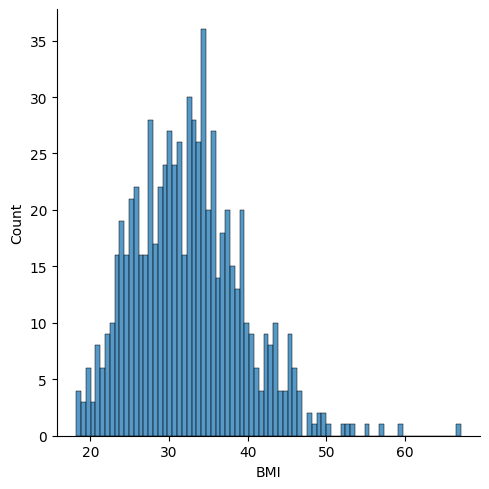

In [200]:
# target인 BMI에 대한 분포 확인하기

sns.displot(df['BMI'], bins=80)
plt.show()

모델을 더욱 **일반화하기 위해서** data augmentation을 고려해보았다. data augmentation은 **imblearn 라이브러리의 ADASYN**을 이용할 것이다. 보통은 데이터 불균형 문제를 위해서 classification problem에서 많이 사용되기는 하지만, 여기서의 목적은 **minority class의 데이터 포인트를 늘려 학습을 개선시키고 싶은 것이다.** 위 histplot을 보았을 때, BMI가 30~40 구간에서는 몰려있지만, 나머지 부분에서는 데이터가 많지 않다. 따라서 기존 데이터의 분포를 보강하기 위하여 사용한다.

하지만, 위 과정을 수행하고자 할 때, 아래와 같은 에러 메세지가 출력되었고, 따라서, **SMOTE를 이용하기로 결정**하였다. SMOTE는 선형 보간을 사용하여 데이터를 증강한다.

```
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.
```

그러나, **SMOTE 또한 아래와 같은 에러 메세지 출력**하였고, 결국엔 Gaussian Noise를 메소드로 직접 작성하기로 하였다.

증강할 구간은 아래와 같다.

- **BMI가 20~25인 구간에서의 데이터**
- **BMI가 40~50인 구간에서의 데이터**

In [201]:
# split the input, target

diabetes_input = df.drop(columns=['Outcome', 'BMI']) # input에 Outcome과 BMI는 제외시켜야 함
diabetes_target = df['BMI']

print (diabetes_input.head())
print ('\n')
print (diabetes_target.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0            6      148             72             35        0   
1            1       85             66             29        0   
2            8      183             64              0        0   
3            1       89             66             23       94   
4            0      137             40             35      168   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  


0    33.6
1    26.6
2    23.3
3    28.1
4    43.1
Name: BMI, dtype: float64


In [202]:
# 데이터에 Gaussian Noise 추가

def gaussian_noise(X, y, noise_level=0.01) :
    noise = np.random.normal(0, noise_level, X.shape)
    X_noisy = X + noise
    
    y_noise = y + np.random.normal(0, noise_level, y.shape)
    
    return X_noisy, y_noise

# 20 ~ 25
range1_min, range1_max = 20, 25
filtered_data1 = df[(df['BMI'] >= range1_min) & (df['BMI'] <= range1_max)]
diabetes_input_filtered1 = filtered_data1.drop(columns=['Outcome', 'BMI'])
diabetes_target_filtered1 = filtered_data1['BMI']

# 40 ~ 50
range2_min, range2_max = 40, 50
filtered_data2 = df[(df['BMI'] >= range2_min) & (df['BMI'] <= range2_max)]
diabetes_input_filtered2 = filtered_data2.drop(columns=['Outcome', 'BMI'])
diabetes_target_filtered2 = filtered_data2['BMI']

# 20 ~ 25를 증강한다
diabetes_input_noisy1, diabetes_target_noisy1 = gaussian_noise(diabetes_input_filtered1, diabetes_target_filtered1, noise_level=0.4)

# 40 ~ 50을 증강한다
diabetes_input_noisy2, diabetes_target_noisy2 = gaussian_noise(diabetes_input_filtered2, diabetes_target_filtered2, noise_level=0.4)


df_noisy1 = pd.concat([pd.DataFrame(diabetes_input_noisy1, columns=diabetes_input.columns),
                       pd.Series(diabetes_target_noisy1, name='BMI')],
                      axis=1)
df_noisy2 = pd.concat([pd.DataFrame(diabetes_input_noisy2, columns=diabetes_input.columns),
                       pd.Series(diabetes_target_noisy2, name='BMI')],
                      axis=1)


df = pd.concat([df, df_noisy1, df_noisy2], axis=0) # 증강한 데이터들 합치기

print(df.head())
print(df.shape)


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0          6.0    148.0           72.0           35.0      0.0  33.6   
1          1.0     85.0           66.0           29.0      0.0  26.6   
2          8.0    183.0           64.0            0.0      0.0  23.3   
3          1.0     89.0           66.0           23.0     94.0  28.1   
4          0.0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction   Age  Outcome  
0                     0.627  50.0      1.0  
1                     0.351  31.0      0.0  
2                     0.672  32.0      1.0  
3                     0.167  21.0      0.0  
4                     2.288  33.0      1.0  
(902, 9)


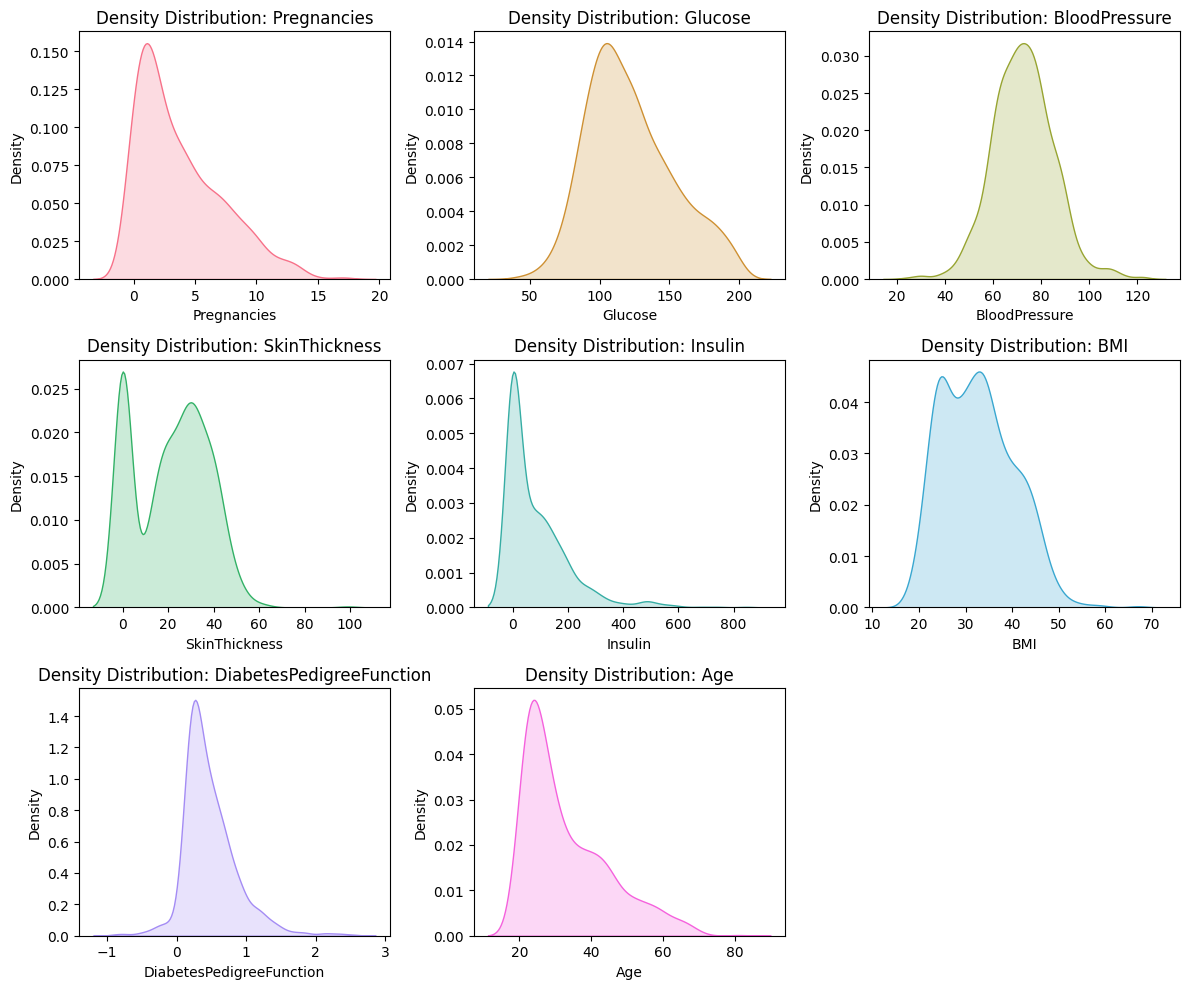

In [203]:
# 정규화 전, 각 feature마다 분포 확인하기

features = df.columns[:-1]  # 'Outcome' 제외

plt.figure(figsize=(12, 10))

for i, feature in enumerate (features) :
    plt.subplot(3, 3, i+1)
    sns.kdeplot(df[feature], fill=True, color=sns.color_palette("husl", len(features))[i])
    plt.title(f'Density Distribution: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

- 위 density distribution을 확인해보니, 대부분이 왼쪽으로 치우친 분포 모형을 띄고 있다. 
- 전체적인 normalization으로 모든 수치의 범위를 0~1로 조정한다.

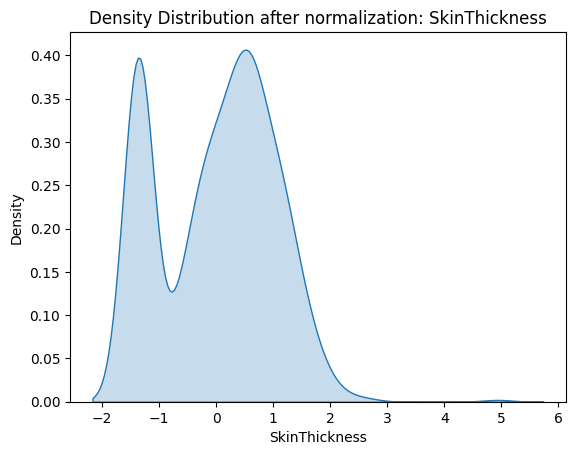

In [204]:
# Z-score normalization

from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
diabetes_input_scaled = pd.DataFrame(normalizer.fit_transform(diabetes_input), 
                              columns=[feature for feature in features if feature != 'BMI'])  

# 예시로, SkinThickness를 시각화하여 normalization이 잘 되었는지 확인해보기
sns.kdeplot(diabetes_input_scaled['SkinThickness'], fill=True)
plt.title(f'Density Distribution after normalization: SkinThickness')
plt.xlabel('SkinThickness')
plt.ylabel('Density')
plt.show()

In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(diabetes_input_scaled,
                                                    diabetes_target,
                                                    test_size = 0.1) 

X_train.shape, y_train.shape 

((651, 7), (651,))

In [206]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
    # find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

'''
    이 함수로 순환형 데이터를 구성할 것
'''

'\n    이 함수로 순환형 데이터를 구성할 것\n'

**split_sequence에 대한 자세한 관찰은 https://github.com/lky473736/learning-AI/blob/main/insight/insight_3_split_sequence_and_CNN.ipynb 을 참고.**

- (1) 이 함수는 특정 스텝에 따라 X의 component를 각각 생성 후, 그에 따른 y값은 X component의 마지막 인덱스 + 1의 값을 지정하여 dataset을 만드는 과정을 담고 있다는 것을 확인 가능하다. 잘 생각해보면, X와 y가 서로 붙어서 전진하면서 dataset을 이룬다. 
- (2) index out of range 문제를 해결하기 위하여, 만약 최종 인덱스보다 마지막 인덱스가 크다면, 즉 y가 존재할 인덱스가 마지막 인덱스보다 크다면 범위를 벗어나는 것이기에 반복문을 종료하는 것을 알 수 있다.
- (3) time-series data이기 때문에 각 데이터들의 선후관계 및 순서가 중요한 상황에서 사용된다.

In [207]:
train_set = np.c_[X_train, y_train]
test_set = np.c_[X_test, y_test]

print ("before : ", train_set.shape, test_set.shape)

X_train_seq, y_train_seq = split_sequences(train_set, 3) # 3개씩 묶기
print (X_train_seq)
print (y_train_seq)

print ("train : ", X_train_seq.shape, y_train_seq.shape)

X_test_seq, y_test_seq = split_sequences(test_set, 3)
print (X_test_seq)
print (y_test_seq)

print ("test : ", X_test_seq.shape, y_test_seq.shape)

before :  (651, 8) (73, 8)
[[[-0.55528445 -0.02872215 -0.19404178 ...  0.08984021  1.23834043
   -0.88037728]
  [ 2.12290466  0.16653451  2.71591501 ... -0.72257227 -0.85750585
    1.50112903]
  [ 0.33744525  0.71976169  0.77594382 ...  1.71466516 -0.06855222
    2.0965056 ]]

 [[ 2.12290466  0.16653451  2.71591501 ... -0.72257227 -0.85750585
    1.50112903]
  [ 0.33744525  0.71976169  0.77594382 ...  1.71466516 -0.06855222
    2.0965056 ]
  [-1.15043759  2.47707157 -0.51737031 ...  1.62059635  0.08201145
   -0.4551083 ]]

 [[ 0.33744525  0.71976169  0.77594382 ...  1.71466516 -0.06855222
    2.0965056 ]
  [-1.15043759  2.47707157 -0.51737031 ...  1.62059635  0.08201145
   -0.4551083 ]
  [-0.25770788 -1.07009096  0.12928675 ...  0.0043231   0.22956384
    0.39542967]]

 ...

 [[-0.25770788 -0.3541499  -0.84069884 ... -0.72257227 -1.00204697
   -1.05048488]
  [-0.55528445 -1.26534762 -0.51737031 ... -0.29498676  0.06695508
   -0.96543108]
  [-0.55528445 -0.71212043 -0.19404178 ... -0.23

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 3, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 3, 32)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 3, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 2, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 2, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 2, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,489 (13.63 KB)

 Trainable params: 3,361 (13.13 KB)

 Non-trainable params: 128 (512.00 B)

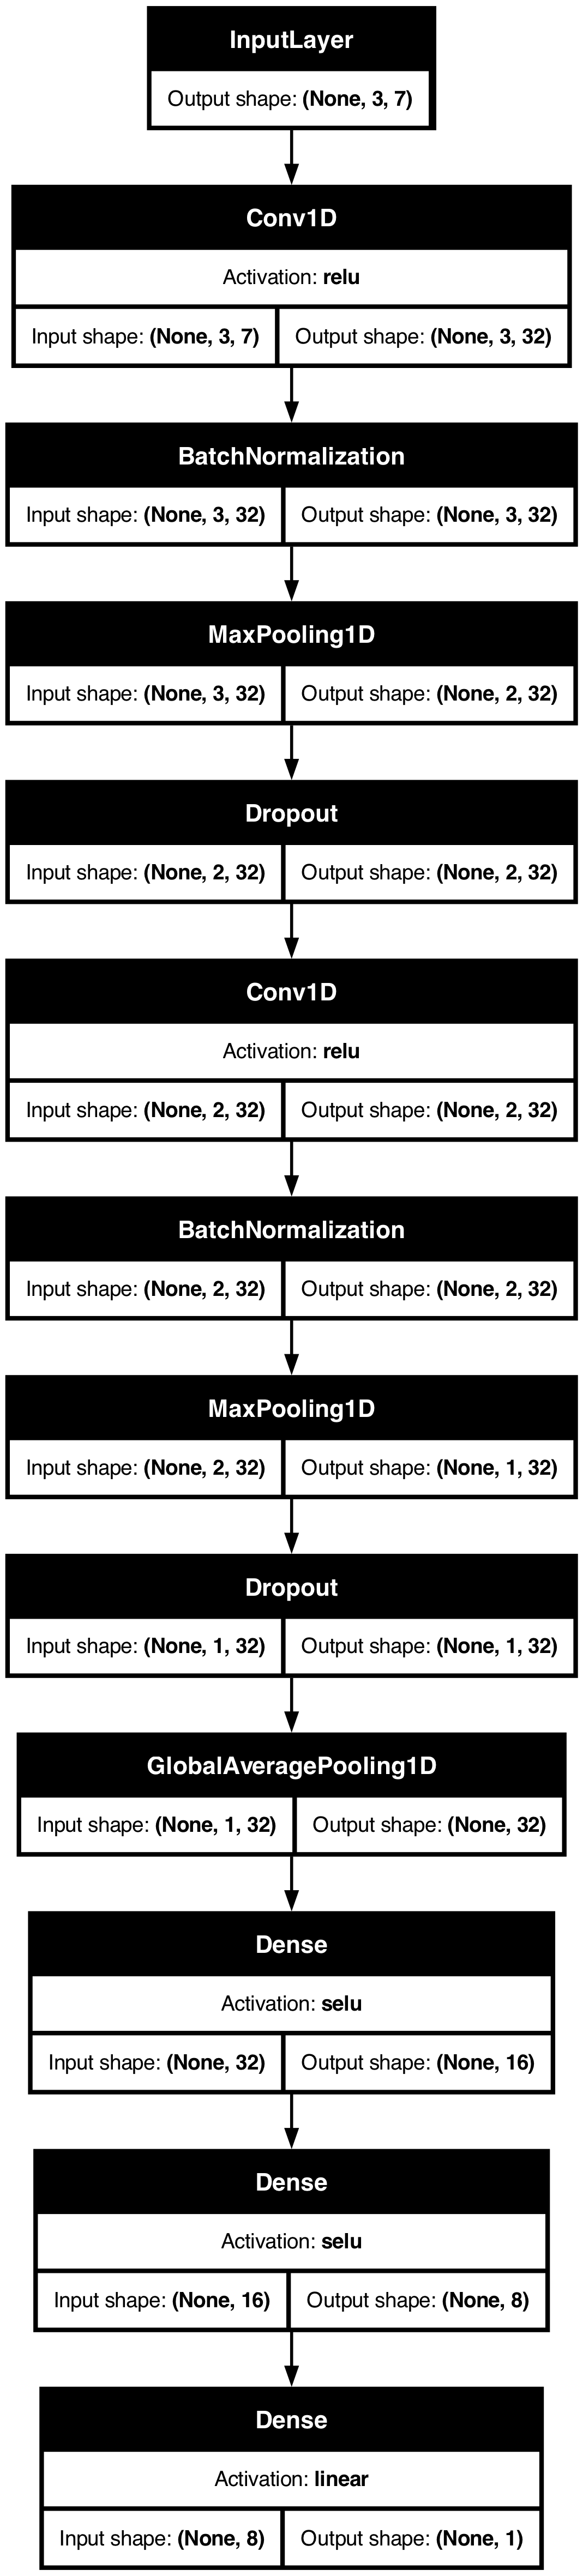

In [208]:
# modeling

from tensorflow.keras import regularizers

input_layer = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# 첫 번째 Conv1D 레이어 + BatchNormalization + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(32, kernel_size=2, activation='relu', padding='same', 
                             kernel_regularizer=regularizers.l2(0.001))(input_layer)
batch_1 = keras.layers.BatchNormalization()(conv_1)
pooling_1 = keras.layers.MaxPooling1D(2, padding='same')(batch_1)
dropout_1 = keras.layers.Dropout(0.2)(pooling_1)

# 두 번째 Conv1D 레이어 + BatchNormalization + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(32, kernel_size=2, activation='relu', padding='same', 
                             kernel_regularizer=regularizers.l2(0.001))(dropout_1)
batch_2 = keras.layers.BatchNormalization()(conv_2)
pooling_2 = keras.layers.MaxPooling1D(2, padding='same')(batch_2)
dropout_2 = keras.layers.Dropout(0.2)(pooling_2)

# flatten 대신에 pooling1D를 사용해봄
global_pool = keras.layers.GlobalAveragePooling1D()(dropout_2)

'''
    계속적으로 val_loss가 늘어나는 현상 발견
    regularizer를 추가하여 l2 규제를 하게끔 함
    l1 규제 : 절댓값 규제 (특정 feature을 0으로 만들 수 있음)
    l2 규제 : 제곱 규제 (특정 feature을 0과 가깝게 만들 수 있음)
'''

# Dense 레이어
dense_1 = keras.layers.Dense(16, activation='selu', 
                             kernel_regularizer=regularizers.l2(0.001))(global_pool)
dense_2 = keras.layers.Dense(8, activation='selu', 
                             kernel_regularizer=regularizers.l2(0.001))(dense_1)

output_layer = keras.layers.Dense(1)(dense_2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [209]:
# compile

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile (optimizer=optimizer, 
               loss='mse', 
               metrics=['mae'])

In [210]:
# fit

# early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
#                                                 restore_best_weights=True)

from memory_profiler import profile

@profile # 메모리 오버플로우로 인한 시스템 다운을 막기 위해서
def train_model() :
    history = model.fit(X_train_seq, y_train_seq, epochs=120, 
                        validation_split=0.1, 
#                         callbacks=early_stopping_cb, 
                        verbose=True)
    
    return history
    
history = train_model()
print (history)

ERROR: Could not find file /var/folders/_z/gryfr07n59jgb3wrd062h1ym0000gn/T/ipykernel_14388/1274276972.py
Epoch 1/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 1086.1802 - mae: 32.2478 - val_loss: 1097.2734 - val_mae: 32.4336
Epoch 2/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1058.8832 - mae: 31.8411 - val_loss: 1070.3481 - val_mae: 32.0209
Epoch 3/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 997.2488 - mae: 30.9039 - val_loss: 1042.1914 - val_mae: 31.5857
Epoch 4/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 924.9388 - mae: 29.7088 - val_loss: 1007.8383 - val_mae: 31.0488
Epoch 5/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 895.3727 - mae: 29.1096 - val_loss: 962.3413 - val_mae: 30.3184
Epoch 6/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 774.6506 - mae: 26.8824 - val_loss: 898.3184 - val_mae: 29.2573
Epoch 7/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 710.4431 - mae: 25.6236 - val_loss: 813.5900 - val_mae: 27.7833
Epoch 8/120
19/19 ━━━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.9584 - mae: 5.1833 - val_loss: 35.7427 - val_mae: 4.7722
Epoch 54/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.4931 - mae: 4.8837 - val_loss: 34.3774 - val_mae: 4.6733
Epoch 55/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.8839 - mae: 4.9314 - val_loss: 35.5328 - val_mae: 4.7517
Epoch 56/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.6634 - mae: 4.8395 - val_loss: 36.0682 - val_mae: 4.8128
Epoch 57/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.1685 - mae: 5.0849 - val_loss: 35.0030 - val_mae: 4.7313
Epoch 58/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.2637 - mae: 4.9008 - val_loss: 35.0747 - val_mae: 4.7443
Epoch 59/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.1091 - mae: 4.9524 - val_loss: 34.8905 - val_mae: 4.7372
Epoch 60/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.4725 - mae: 4.7042 - val_loss: 34.5343 - val_mae: 4.7083
Epoch 61/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.2775 - mae: 4.2137 - val_loss: 34.6335 - val_mae: 4.6537
Epoch 107/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.0405 - mae: 4.3484 - val_loss: 34.5115 - val_mae: 4.6596
Epoch 108/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.3185 - mae: 4.2784 - val_loss: 33.8796 - val_mae: 4.6222
Epoch 109/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.5684 - mae: 4.3977 - val_loss: 34.6291 - val_mae: 4.6695
Epoch 110/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.6037 - mae: 4.5744 - val_loss: 34.6621 - val_mae: 4.6758
Epoch 111/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.0648 - mae: 4.1710 - val_loss: 34.4140 - val_mae: 4.6439
Epoch 112/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.9367 - mae: 4.2383 - val_loss: 34.3516 - val_mae: 4.6293
Epoch 113/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.2724 - mae: 4.1387 - val_loss: 34.6302 - val_mae: 4.6344
Epoch 114/120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4m

{'loss': [1109.4881591796875, 1046.833740234375, 990.5614013671875, 929.7449951171875, 858.8281860351562, 769.5560913085938, 679.1787109375, 568.2590942382812, 465.53814697265625, 357.98565673828125, 263.4958190917969, 198.1576385498047, 146.06484985351562, 122.40798950195312, 95.68014526367188, 76.15477752685547, 76.80491638183594, 77.68639373779297, 75.75761413574219, 69.50350189208984, 69.78974151611328, 67.40335083007812, 60.726234436035156, 66.34773254394531, 60.81154251098633, 55.97303009033203, 55.56034851074219, 51.64241409301758, 52.704776763916016, 49.83896255493164, 52.09431838989258, 58.94077682495117, 51.672000885009766, 52.520286560058594, 52.99357604980469, 46.301475524902344, 46.226219177246094, 51.205299377441406, 47.68072509765625, 47.684146881103516, 44.613338470458984, 45.93894958496094, 47.55738830566406, 45.30656051635742, 43.69219970703125, 41.971866607666016, 46.077396392822266, 40.11246109008789, 42.65471267700195, 42.34648895263672, 40.904903411865234, 44.6338

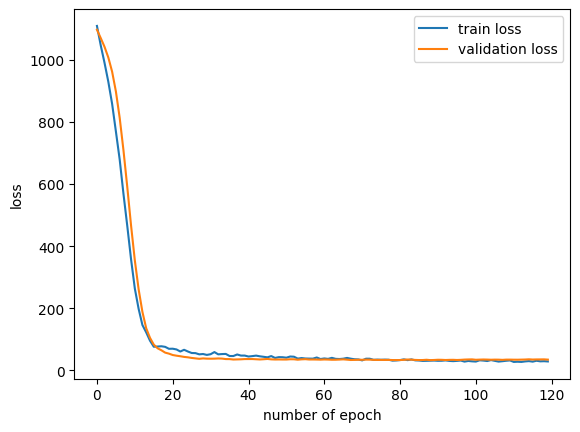

In [211]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [212]:
# MSE, MAE 구하기

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_test_pred = model.predict(X_test_seq)

print (y_test_pred)

mse = mean_squared_error(y_test_seq, y_test_pred)
mae = mean_absolute_error(y_test_seq, y_test_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[30.292894]
 [37.920708]
 [34.15794 ]
 [32.00064 ]
 [30.133001]
 [27.10903 ]
 [30.436865]
 [33.524933]
 [29.405916]
 [33.931347]
 [26.228899]
 [32.831352]
 [32.898624]
 [29.570791]
 [29.814966]
 [24.043695]
 [36.00842 ]
 [30.397573]
 [30.22686 ]
 [29.692213]
 [42.775856]
 [28.381304]
 [35.407043]
 [25.942284]
 [31.762514]
 [37.135353]
 [28.44031 ]
 [37.82678 ]
 [35.819824]
 [37.314583]
 [35.828304]
 [27.985186]
 [36.15733 ]
 [36.005573]
 [26.26475 ]
 [34.63694 ]
 [28.136854]
 [29.712679]
 [31.128498]
 [25.272911]
 [41.067158]
 [34.42062 ]
 [34.112446]
 [35.491966]
 [38.3229  ]
 [27.23424 ]
 [31.022612]
 [26.655518]
 [25.717245]
 [41.83189 ]
 [30.296837]
 [35.44522 ]
 [28.764935]
 [33.934364]
 [29.112108]
 [29.319387]
 [32.41905 ]
 [33.334522]
 [31.877058]
 [27.24946 ]
 [29.589422]
 [31.963938]
 [32.419415]
 [34.859375]
 [32.09643 ]
 [26.824417]
 [33.509087]
 [32.765575]
 [31.46481 ]
 [27.861197]
 [32.401268]]
MSE: 49.120438015897534
MAE: 5.0923591

R^2 Score: 0.293


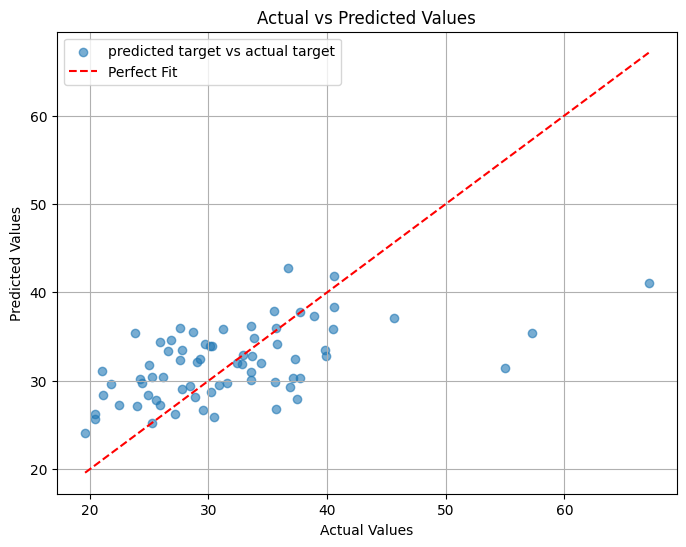

In [213]:
from sklearn.metrics import r2_score

# R^2 값 계산
r2 = r2_score(y_test_seq, y_test_pred)
print(f'R^2 Score: {r2:.3f}')

# 예측값과 실제값 시각화
plt.figure(figsize=(8, 6))
plt.scatter(y_test_seq, y_test_pred, alpha=0.6, 
            label='predicted target vs actual target')
plt.plot([min(y_test_seq), max(y_test_seq)], 
         [min(y_test_seq), max(y_test_seq)], 
         color='red', linestyle='--', 
         label='Perfect Fit')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()